In [1]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [1]:
%reload_ext autoreload
%autoreload 2

# DATASCI W261 - Machine Learning At Scale
## Assignment - Week 09
---
__Name:__  Carlos Eduardo Rodriguez Castillo   
__Class:__ W261 - Section 2     
__Email:__  cerodriguez@ischool.berkeley.edu     
__Week:__   09 


---
### Instructions

Due by 07/17/2016

[Submission Link - Google Form](https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form) 

### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
### Useful References

* Data-intensive text processing with MapReduce. San Rafael, CA: Morgan & Claypool Publishers. Chapter 5. 


---

<h2 style="color:red">HW 9 Dataset</h2>

Note that all referenced files life in the enclosing directory. [Checkout the Data subdirectory on Dropbox](https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0) or the AWS S3 buckets (details contained each question). 

<h2 style="color:red"> HW 9.0: Short answer questions </h2>

__What is PageRank and what is it used for in the context of web search?__

##### ANSWER:

PageRank is an algorithm for ranking the relevance or popularity of nodes in a graph based on the steady-state probability distribution of the nodes in the graph.

PageRank is the backbone of modern web search. Larry Page and Sergei Brin used PageRank as the core of the Google search engine which critically aided them in making Google the most popular web search solution in the world. Part of the reason that PageRank was so novel and successful in providing a solution for web search is that the underlyiung algortihm prioritization of pages was independent of the runtime query being executed by the user (this was later on added into the solution).

<hr>

__What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to compute the Steady State Distibution?__

##### ANSWER:

In order to leverage the machinery of Markov Chains to compute the steady-state distribution the webgraph needs several modifications. These modifications need to be put in place primarily to comply with the assumptions required for a graph to be well behaved (irreducibility and aperiodicity). The modifications are:

- The graph nodes are initialized with a page rank score that is used as a starting point for the iterative algorithm that is meant to arrive at the final page rank scores in the steady state distribution of the graph.
- While it is not a change to the graph itself, in order to fulfill the irreducibility requirement, we must introduce the concept of teleportation from any node to any other node in the graph by enhancing the transition matrix with a uniform transition matrix. This transition matrix is combined with the vanilla transition matrix to arrive at a steady state distribution via a dampening factor (i.e. the dampening factor determines how important the uniform transition matrix is in computing the steady state distribution).
- Another important piece to consider (again not tied to graph representation explicitly but rather to the treatment of the graph) is that, to deal with web pages that do not have outlinks (i.e. dangling nodes in the graph) at each iteration of the algorithm the probability mass of these webpages needs to be uniformly distributed across all web pages in the graph.

<hr>

__ OPTIONAL: In topic-specific pagerank, how can we ensure that the irreducible property is satifsied? (HINT: see HW9.4) __

##### ANSWER:

To ensure that the irreducibility property is satisfied in topic-specific pagerank we would need to be required to alter the graph by exclusively maintaining edges in the graph that contain non-zero nodes in the topic for the topic-specific pagernk being computed. This would need to be done separately for each topic-specific pagerank vector being constructed.

This can also be achieved by implementing a non-uniform dampening factor that takes into consideration the number of nodes in the topic of interest as well as the topic of the node being processed.

<hr>


<h2 style="color:red"> HW 9.1: MRJob implementation of basic PageRank </h2>

Write a basic MRJob implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input (as explored in HW 7).

Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1).


[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page, chooses the next page to which it will move by clicking at random, with probability d,one of the hyperlinks in the current page. This probability is represented by a so-called *damping factor* d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer jumps to any web page in the network. If a page is a dangling end, meaning it has no outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform distribution and “teleports” to that page]


As you build your code, use the test data:

> s3://ucb-mids-mls-networks/PageRank-test.txt

Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
> Dropbox: https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck your work with the true result, displayed in the first image in the [Wikipedia article](https://en.wikipedia.org/wiki/PageRank)
and here for reference are the corresponding PageRank probabilities:
<pre>

A, 0.033
B, 0.384
C, 0.343
D, 0.039
E, 0.081
F, 0.039
G, 0.016
H, 0.016
I, 0.016
J, 0.016
K, 0.016

</pre>

<h2 style="color:darkgreen"> HW 9.1 Implementation </h2>

In [308]:
%%writefile PageRank_graph_prep_2.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class MRpageRankGraphPrep(MRJob):
    
    num_nodes = 0
    
    def step(self):
        
        return [
            MRStep(
                   mapper=self.mapper,
                   reducer=self.reducer)
        ]
    
    ## The mapper emits all nodes and their neighbors
    def mapper(self, _, line):
        line = line.strip()
        key, value = line.split("\t")
        neighbors = ast.literal_eval(value)
        neighbors_array = []
        for n in neighbors.keys():
            neighbors_array.append(n)
            yield n, "-"
        yield key, neighbors_array
        
    def reducer(self, key, values):
        neighbors = []
        ## the reducer increments a counter for the 
        ## number of nodes as it encounters each new key
        self.increment_counter("Nodes","Num_nodes",1)
        for v in values:
            if neighbors == "":
                if v != "-":
                    neighbors = v
            else:
                if v != "-":
                    neighbors.extend(v)
        yield key, (neighbors, 1.0)
        
if __name__ == "__main__":
    MRpageRankGraphPrep.run()

Overwriting PageRank_graph_prep_2.py


In [309]:
!chmod a+x PageRank_graph_prep_2.py

In [524]:
%%writefile PageRank_step3.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class MRpageRank3(MRJob):
    
    ## Hardcoding the parameters for the job
    ## these are substituted with runtime parameters
    N = 1
    alpha = 0.0
    first_run = 0
    dangling_mass = 0.0
    
    ## function permits us to pass an arbitrary alpha, a binary first run indicator
    ## and the number of nodes on the graph to our mrjob
    def configure_options(self):
        super(MRpageRank3, self).configure_options()
        self.add_passthrough_option('--alpha', type='float', default=0.1, help='The damping factor; must be a float!')
        self.add_passthrough_option('--first-run', type='int', default=0, help='Indicates whether we are dealing with the first run of algo')
        self.add_passthrough_option('--num-nodes', type='int', default=1, help='The number of nodes in the graph; must be an int!')
    
    def steps(self):
        return [
            MRStep(
            mapper_init=self.mapper_init,
            mapper=self.mapper,
            reducer_init=self.reducer_init,
            reducer=self.reducer)
        ]
    
    def mapper_init(self):
        self.N = self.options.num_nodes
        self.first_run = self.options.first_run
    
    def mapper(self, _, line):
        line = line.strip()
        key, value = line.split("\t")
        key = key.strip('"')
        value = ast.literal_eval(value)
        neighbors = value[0]
        ## if this is the first iterative step in the
        ## algorithm we must initialize the pagerank
        ## values for all nodes
        if self.first_run == 1:
            PR = float(value[1]) / float(self.N)
        else:
            PR = float(value[1])
        ## we emit a special key when we encounter a 
        ## dangling node
        if neighbors == []:
            yield "*dangling", ("-", float(PR))
            yield key, (neighbors, 0.0)
        else:
            num_nieghbors = len(neighbors)
            ## the pagerank that is passed along the edges
            ## to the nodes neighbors is divided equally 
            ## among the node's neoghbors
            for n in neighbors:
                yield n, ("-",float(PR)/float(num_nieghbors))
            yield key, (neighbors, 0.0)
    
    def reducer_init(self):
        self.N = self.options.num_nodes
    
    def reducer(self, key, values):
        dangling_mass = 0.0
        ## if a dangling mass special key is encountered,
        ## we accumulate the dangling mass, transform it to
        ## an integer and finally store it in a counter
        if key == "*dangling":
            for v in values:
                dangling_mass += v[1]
            TEN_BILLION = 10000000000
            self.increment_counter("dangling_nodes","mass", int(dangling_mass*TEN_BILLION))
        else:
            new_PR = 0.0
            neighbors = ""
            for v in values:
                new_PR += v[1]
                if v[0] != "-":
                    neighbors = v[0]
            yield key, (neighbors, new_PR)
        
if __name__ == "__main__":
    MRpageRank3.run()

Overwriting PageRank_step3.py


In [525]:
!chmod a+x PageRank_step3.py

In [526]:
%%writefile PageRank_step35.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class MRpageRank35(MRJob):
    
    ## Hardcoding the job parameters
    ## these are substituted with runtime parameters
    N = 1
    alpha = 0.0
    first_run = 0
    dangling_mass = 0.0
    
    ## function permits us to pass an arbitrary alpha, number of nodes
    ## and dangling node mass to our mrjob
    def configure_options(self):
        super(MRpageRank35, self).configure_options()
        self.add_passthrough_option('--alpha', type='float', default=0.1, help='The damping factor; must be a float!')
        self.add_passthrough_option('--num-nodes', type='int', default=1, help='The number of nodes in the graph; must be an int!')
        self.add_passthrough_option('--dangling-mass', type='float', default=0.0, help='The dangling mass for iteration; must be a float!')
    
    def steps(self):
        return [
            MRStep(
            mapper_init=self.mapper_init,
            mapper=self.mapper)
        ]
    
    def mapper_init(self):
        self.alpha = self.options.alpha
        self.N = self.options.num_nodes
        self.dangling_mass = self.options.dangling_mass
    
    def mapper(self, _, line):
        line = line.strip()
        key, value = line.split("\t")
        key = key.strip('"')
        value = ast.literal_eval(value)
        neighbors = value[0]
        PR = float(value[1])
        ## we simply compute the final pagerank for the node
        PR = self.alpha * 1.00/float(self.N) + (1 - self.alpha) * (PR  + (self.dangling_mass / float(self.N)))
        yield key, (neighbors, PR)
        
if __name__ == "__main__":
    MRpageRank35.run()

Overwriting PageRank_step35.py


In [527]:
!chmod a+x PageRank_step35.py

#### PageRank - Local Implementation - Toy graph

In [529]:
%reload_ext autoreload
%autoreload 2

from numpy import random,array
from PageRank_graph_prep_2 import MRpageRankGraphPrep
from PageRank_step3 import MRpageRank3
from PageRank_step35 import MRpageRank35
import ast
import os

!rm -r /home/cloudera/w261/HW9/data/toy_prepared_graph_input
!rm -r /home/cloudera/w261/HW9/data/toy_prepared_graph_output
!mkdir /home/cloudera/w261/HW9/data/toy_prepared_graph_input
!rm -r /home/cloudera/w261/HW9/data/toy_prepared_graph_output_intermediate


mr_job = MRpageRankGraphPrep(args=["/home/cloudera/w261/HW9/data/toy/example_1.txt",
                                    "--output-dir",
                                    "/home/cloudera/w261/HW9/data/toy_prepared_graph_input"])

with mr_job.make_runner() as runner: 
        runner.run()
        counters = runner.counters()[0]
        num_nodes = counters['Nodes']['Num_nodes']

i = 0
TEN_BILLION = 10000000000
while(1):
    if i == 0:
        first_run = 1
    else:
        first_run = 0
    mr_job = MRpageRank3(args=["/home/cloudera/w261/HW9/data/toy_prepared_graph_input",
                               "--alpha",0.15,
                               "--num-nodes", str(num_nodes),
                               "--first-run", str(first_run),
                               "--output-dir",
                               "/home/cloudera/w261/HW9/data/toy_prepared_graph_output_intermediate"])
    
    print "iteration "+str(i)+" of Pagerank algorithm"

    with mr_job.make_runner() as runner: 
        runner.run()
        counters = runner.counters()[0]
        dangling_nodes_mass = float(counters["dangling_nodes"]["mass"]) / float(TEN_BILLION)
        
    mr_job = MRpageRank35(args=["/home/cloudera/w261/HW9/data/toy_prepared_graph_output_intermediate",
                               "--alpha",0.15,
                               "--num-nodes", str(num_nodes),
                               "--dangling-mass",str(dangling_nodes_mass),
                                "--output-dir",
                               "/home/cloudera/w261/HW9/data/toy_prepared_graph_output"])
    
    with mr_job.make_runner() as runner: 
        runner.run()
    
    i = i + 1

    !rm -r /home/cloudera/w261/HW9/data/toy_prepared_graph_input
    !rm -r /home/cloudera/w261/HW9/data/toy_prepared_graph_output_intermediate
    !cp -rT /home/cloudera/w261/HW9/data/toy_prepared_graph_output /home/cloudera/w261/HW9/data/toy_prepared_graph_input

    if i >=5:
        break
!cat /home/cloudera/w261/HW9/data/toy_prepared_graph_output/*

rm: cannot remove `/home/cloudera/w261/HW9/data/toy_prepared_graph_output_intermediate': No such file or directory
iteration 0 of Pagerank algorithm
iteration 1 of Pagerank algorithm
iteration 2 of Pagerank algorithm
iteration 3 of Pagerank algorithm
iteration 4 of Pagerank algorithm
"4"	[["1", "2"], 0.04115963361263218]
"5"	[["2", "4", "6"], 0.09396022928696268]
"6"	[["2", "5"], 0.04115963361263218]
"7"	[["2", "5"], 0.016541506363181815]
"8"	[["2", "5"], 0.016541506363181815]
"9"	[["2", "5"], 0.016541506363181815]
"1"	[[], 0.03867493637804221]
"10"	[["5"], 0.016541506363181815]
"11"	[["5"], 0.016541506363181815]
"2"	[["3"], 0.41918431933958356]
"3"	[["2"], 0.28315371577604154]


#### PageRank - EMR Implementation - Toy graph

##### Preprocessing step

In [575]:
%reload_ext autoreload
%autoreload 2

from PageRank_graph_prep_2 import MRpageRankGraphPrep

!aws s3 rm s3://cerc-w261/HW9/toy/prepared_graph_input_fixed --recursive --quiet
!aws s3 rm s3://cerc-w261/HW9/toy/prepared_graph_input --recursive --quiet

mr_job = MRpageRankGraphPrep(args=["-r","emr",
                                   "s3://cerc-w261/HW9/toy/raw_input",
                                   "--cluster-id=j-1MCQ877VHZCQ7",
                                   "--aws-region=us-west-2",
                                    "--output-dir",
                                    "s3://cerc-w261/HW9/toy/prepared_graph_input_fixed"])

with mr_job.make_runner() as runner: 
        runner.run()
        counters = runner.counters()[0]
        num_nodes = counters['Nodes']['Num_nodes']
        
!aws s3 cp s3://cerc-w261/HW9/toy/prepared_graph_input_fixed s3://cerc-w261/HW9/toy/prepared_graph_input --recursive --quiet

##### Iterative PageRank steps

In [577]:
from numpy import random,array
from PageRank_graph_prep_2 import MRpageRankGraphPrep
from PageRank_step3 import MRpageRank3
from PageRank_step35 import MRpageRank35
import ast
import os

!aws s3 cp s3://cerc-w261/HW9/toy/prepared_graph_input_fixed s3://cerc-w261/HW9/toy/prepared_graph_input --recursive --quiet
!aws s3 rm s3://cerc-w261/HW9/toy/prepared_graph_output --recursive --quiet
!aws s3 rm s3://cerc-w261/HW9/toy/prepared_graph_temp_output --recursive --quiet
!aws s3 rm s3://cerc-w261/HW9/toy/prepared_graph_output_intermediate --recursive --quiet

i = 0
TEN_BILLION = 10000000000
while(1):
    if i == 0:
        first_run = 1
    else:
        first_run = 0
    mr_job = MRpageRank3(args=["-r","emr",
                               "s3://cerc-w261/HW9/toy/prepared_graph_input",
                               "--alpha",str(0.15),
                               "--num-nodes", str(num_nodes),
                               "--first-run", str(first_run),
                               "--cluster-id=j-1MCQ877VHZCQ7",
                                "--aws-region=us-west-2",
                               "--output-dir",
                               "s3://cerc-w261/HW9/toy/prepared_graph_temp_output"])
    
    print "iteration "+str(i)+" of Pagerank algorithm"

    with mr_job.make_runner() as runner: 
        runner.run()
        counters = runner.counters()[0]
        dangling_nodes_mass = float(counters["dangling_nodes"]["mass"]) / float(TEN_BILLION)
        
    mr_job = MRpageRank35(args=["-r","emr",
                                "s3://cerc-w261/HW9/toy/prepared_graph_temp_output",
                               "--alpha",str(0.15),
                               "--num-nodes", str(num_nodes),
                               "--dangling-mass",str(dangling_nodes_mass),
                                "--cluster-id=j-1MCQ877VHZCQ7",
                                "--aws-region=us-west-2",
                                "--output-dir",
                               "s3://cerc-w261/HW9/toy/prepared_graph_output"])
    
    with mr_job.make_runner() as runner: 
        runner.run()
    
    i = i + 1

    !aws s3 rm s3://cerc-w261/HW9/toy/prepared_graph_input/ --recursive --quiet
    !aws s3 cp s3://cerc-w261/HW9/toy/prepared_graph_output s3://cerc-w261/HW9/toy/prepared_graph_input --recursive --quiet
    !aws s3 rm s3://cerc-w261/HW9/toy/prepared_graph_temp_output --recursive --quiet
    !aws s3 rm s3://cerc-w261/HW9/toy/prepared_graph_output --recursive --quiet

    if i >=5:
        break

iteration 0 of Pagerank algorithm
iteration 1 of Pagerank algorithm
iteration 2 of Pagerank algorithm
iteration 3 of Pagerank algorithm
iteration 4 of Pagerank algorithm


<h2 style="color:darkgreen">  HW 9.1 Analysis </h2>




<br><br>

The main things to point out about our implementation is that we make strong use of counters to pass critical information (e.g. number of nodes and accumulated danling mass) from mrjob to mrjob thorughout the process. Additionally, we are very deliberate about space, time and network optimization, as is exemplified by the fact that the final job in the iterative algorithmic step uses only mappers such that we may skip the shufle and sort phase of the job, saving precious time and network bandwidth in the process.

<h2 style="color:red"> HW 9.2: Exploring PageRank teleportation and network plots </h2>

* In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
* Using the graph in HW9.1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha, so that each nodes radius is proportional to its PageRank score. 
* In particular you should do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. 
* Note your plots should look like the following: https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

<h2 style="color:darkgreen"> HW 9.2 Implementation </h2>

In [705]:
%reload_ext autoreload
%autoreload 2

from numpy import random,array
from PageRank_graph_prep_2 import MRpageRankGraphPrep
from PageRank_step3 import MRpageRank3
from PageRank_step35 import MRpageRank35
import ast
import os

!rm -r /home/cloudera/w261/HW9/data/toy_prepared_graph_input
!rm -r /home/cloudera/w261/HW9/data/toy_prepared_graph_output
!mkdir /home/cloudera/w261/HW9/data/toy_prepared_graph_input
!rm -r /home/cloudera/w261/HW9/data/toy_prepared_graph_output_intermediate
!rm -r /home/cloudera/w261/HW9/data/toy_prepared_graph_input_fixed


mr_job = MRpageRankGraphPrep(args=["/home/cloudera/w261/HW9/data/toy/example_1.txt",
                                    "--output-dir",
                                    "/home/cloudera/w261/HW9/data/toy_prepared_graph_input"])

with mr_job.make_runner() as runner: 
        runner.run()
        counters = runner.counters()[0]
        num_nodes = counters['Nodes']['Num_nodes']
        
!cp /home/cloudera/w261/HW9/data/toy_prepared_graph_input /home/cloudera/w261/HW9/data/toy_prepared_graph_input_fixed
        
alphas = [0.0, 0.25, 0.5, 0.75, 0.85, 1.0]

for alpha in alphas:
    
    !rm -r /home/cloudera/w261/HW9/data/toy_prepared_graph_output
    !rm -r /home/cloudera/w261/HW9/data/toy_prepared_graph_output_intermediate
    !cp /home/cloudera/w261/HW9/data/toy_prepared_graph_input_fixed /home/cloudera/w261/HW9/data/toy_prepared_graph_input
    
    i = 0
    TEN_BILLION = 10000000000
    while(1):
        if i == 0:
            first_run = 1
        else:
            first_run = 0
        mr_job = MRpageRank3(args=["/home/cloudera/w261/HW9/data/toy_prepared_graph_input",
                                   "--alpha", str(alpha),
                                   "--num-nodes", str(num_nodes),
                                   "--first-run", str(first_run),
                                   "--output-dir",
                                   "/home/cloudera/w261/HW9/data/toy_prepared_graph_output_intermediate"])

        with mr_job.make_runner() as runner: 
            runner.run()
            counters = runner.counters()[0]
            dangling_nodes_mass = float(counters["dangling_nodes"]["mass"]) / float(TEN_BILLION)

        mr_job = MRpageRank35(args=["/home/cloudera/w261/HW9/data/toy_prepared_graph_output_intermediate",
                                   "--alpha", str(alpha),
                                   "--num-nodes", str(num_nodes),
                                   "--dangling-mass",str(dangling_nodes_mass),
                                    "--output-dir",
                                   "/home/cloudera/w261/HW9/data/toy_prepared_graph_output"])

        with mr_job.make_runner() as runner: 
            runner.run()

        i = i + 1

        !rm -r /home/cloudera/w261/HW9/data/toy_prepared_graph_input
        !rm -r /home/cloudera/w261/HW9/data/toy_prepared_graph_output_intermediate
        !cp -rT /home/cloudera/w261/HW9/data/toy_prepared_graph_output /home/cloudera/w261/HW9/data/toy_prepared_graph_input

        if i >=40:
            break
    !cat /home/cloudera/w261/HW9/data/toy_prepared_graph_output/* > "/home/cloudera/w261/HW9/data/draw/input_graph_alpha_"$alpha".txt"

rm: cannot remove `/home/cloudera/w261/HW9/data/toy_prepared_graph_output_intermediate': No such file or directory
rm: cannot remove `/home/cloudera/w261/HW9/data/toy_prepared_graph_input_fixed': No such file or directory
cp: omitting directory `/home/cloudera/w261/HW9/data/toy_prepared_graph_input'
rm: cannot remove `/home/cloudera/w261/HW9/data/toy_prepared_graph_output': No such file or directory
rm: cannot remove `/home/cloudera/w261/HW9/data/toy_prepared_graph_output_intermediate': No such file or directory
cp: cannot stat `/home/cloudera/w261/HW9/data/toy_prepared_graph_input_fixed': No such file or directory
rm: cannot remove `/home/cloudera/w261/HW9/data/toy_prepared_graph_output_intermediate': No such file or directory
cp: cannot stat `/home/cloudera/w261/HW9/data/toy_prepared_graph_input_fixed': No such file or directory
rm: cannot remove `/home/cloudera/w261/HW9/data/toy_prepared_graph_output_intermediate': No such file or directory
cp: cannot stat `/home/cloudera/w261/HW9/d

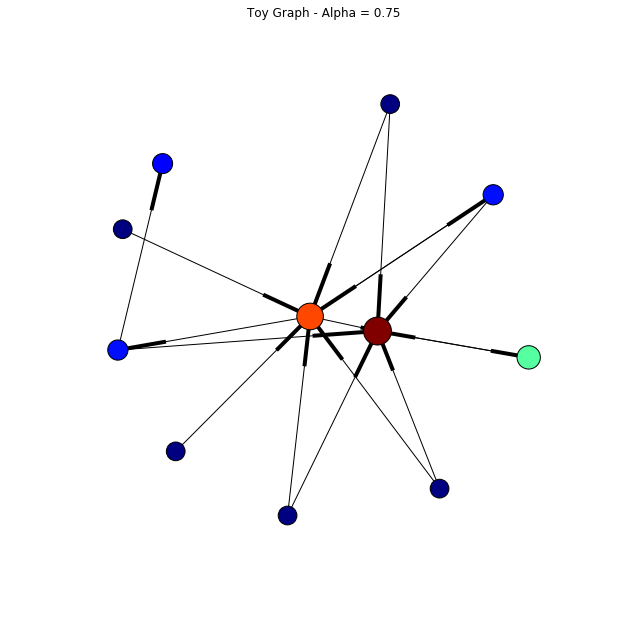

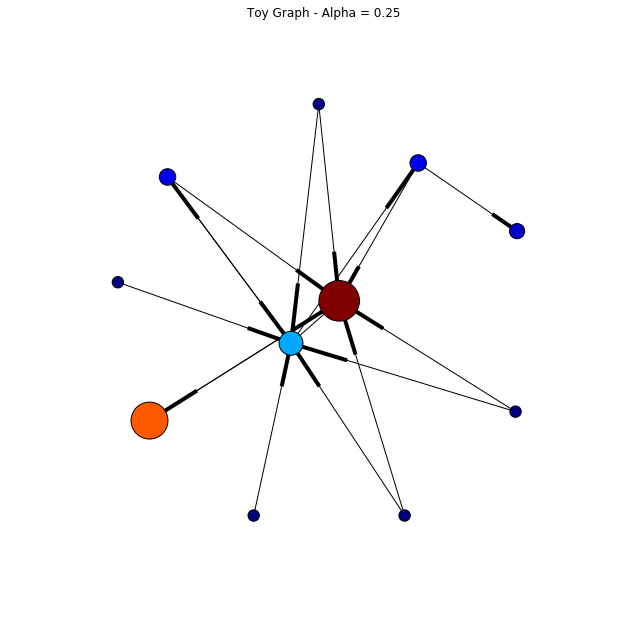

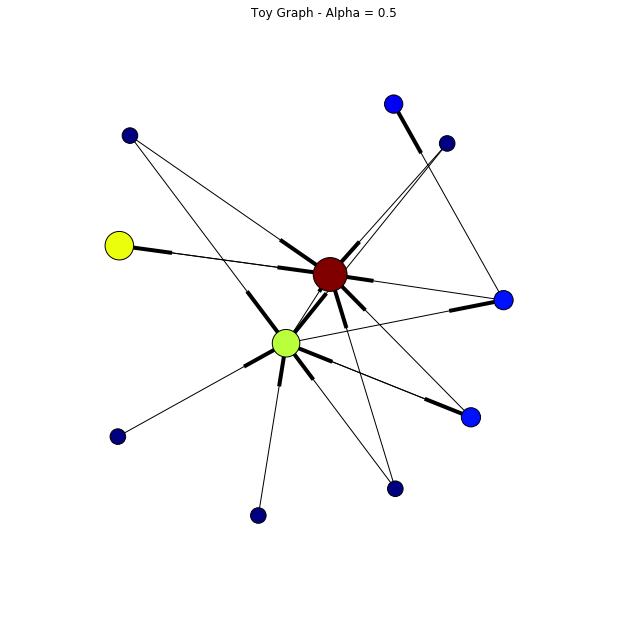

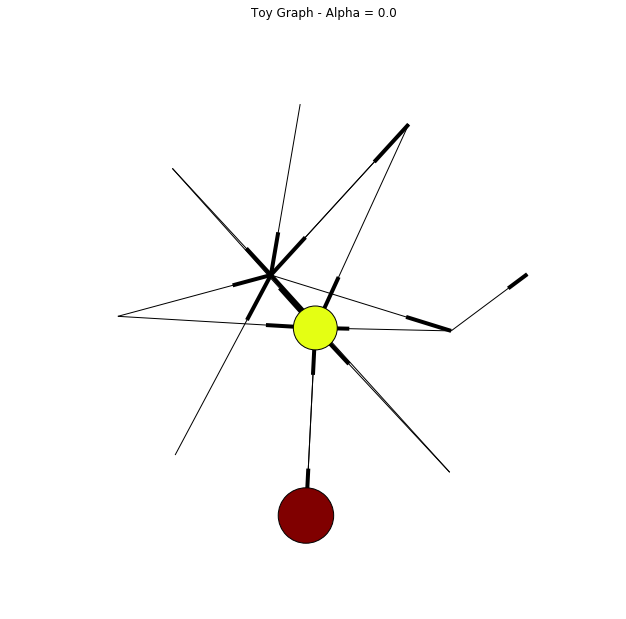

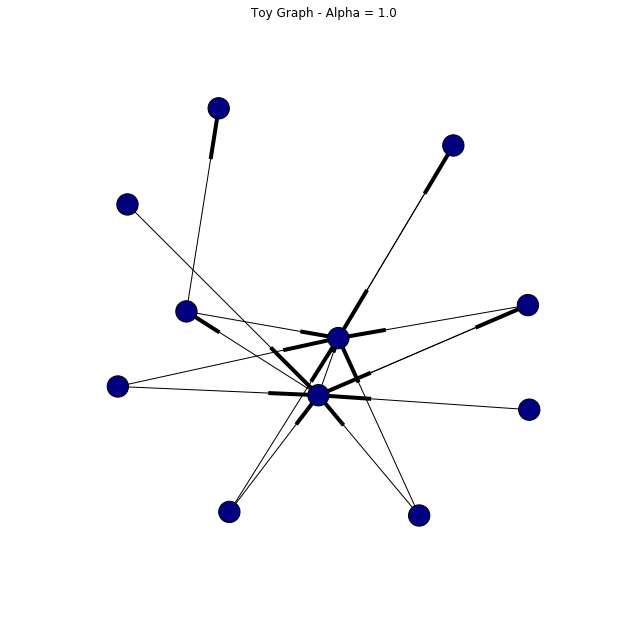

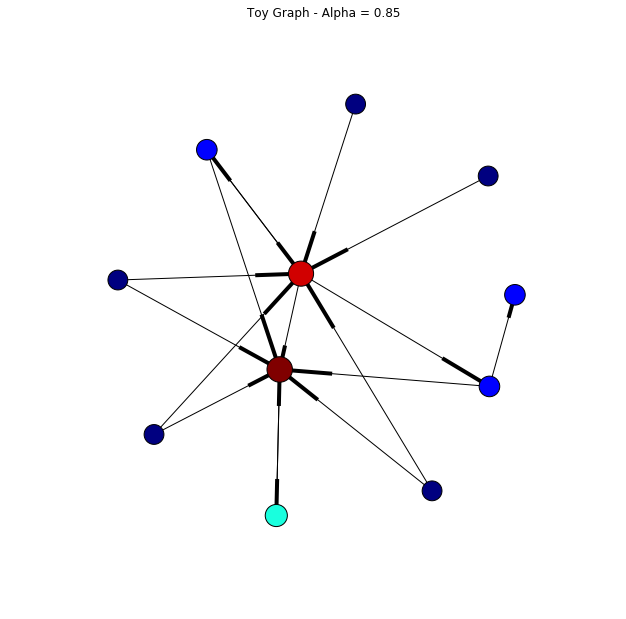

In [724]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os
import ast
import networkx as nx

"""
Python script to visualize pageRank graphs.
"""

def pagerank_graph():

    
    G = nx.Graph()
    G = G.to_directed()
    G.pageRank={}
    
    input_dir = "/home/cloudera/w261/HW9/data/draw_input/"
    
    for name in os.listdir(input_dir):
        with open(input_dir+name) as f:
            for line in f:
                line = line.strip("\n")
                node, payload = line.split("\t")
                node = node.strip('"')
                if node not in G:
                    G.add_node(node)
                payload = ast.literal_eval(payload)
                neighbors = payload[0]
                pageRank = payload[1]
                G.pageRank[node] = pageRank
                for n in neighbors:
                    if n not in G:
                        G.add_node(n)
                    if not G.has_edge(node,n):
                        G.add_edge(node,n)

        plt.figure(figsize=(8,8))
        node_color = [G.pageRank[n]*1000000 for n in G]
        nx.draw(G,
             node_size = [G.pageRank[n]*5000 for n in G],
             node_color = node_color,
             with_labels = False)
        nx.circular_layout(G)
        name_components = name.split("_")
        alpha = name_components[-1].strip(".txt")
        plt.title("Toy Graph - Alpha = %s"%alpha)
        file_name = "/home/cloudera/w261/HW9/data/draw_output/graph_alpha_%s.png"%alpha
        plt.savefig(file_name)

pagerank_graph()

<h2 style="color:darkgreen">  HW 9.2 Analysis </h2>




<br><br>
As one might expect, the dampening factor has a dramatic effect on the end pagerank values for the nodes in the graph. THe graphs above show that, as alpha aproaches 1 the mass of the nodes approaches a uniform distribution of pagerank across all nodes. As alpha approaches 0 we see that the pagerank mass tends to concentrate on the dangling nodes and the nodes directly linked to the dangling nodes.

<h2 style="color:red"> HW 9.3: Applying PageRank to the Wikipedia hyperlinks network </h2>

* Run your PageRank implementation on the Wikipedia dataset for 5 iterations, and display the top 100 ranked nodes (with alpha = 0.85).
* Run your PageRank implementation on the Wikipedia dataset for 10 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15).
* Have the top 100 ranked pages changed? Comment on your findings. 
* Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  


<h2 style="color:darkgreen"> HW 9.3 Implementation </h2>

#### Wikipedia Graph Pagerank implementation

It is important to note that, to optimize for time and resources, I decided to run the iterative step from iterations one through five once, and then use the results from the fifth iteration to compute iterations six through ten.

##### Wikipedia Graph preparation step

In [7]:
%reload_ext autoreload
%autoreload 2

from PageRank_graph_prep_2 import MRpageRankGraphPrep

!aws s3 rm s3://cerc-w261/HW9/wiki/prepared_graph_input_fixed --recursive --quiet
!aws s3 rm s3://cerc-w261/HW9/wiki/prepared_graph_input --recursive --quiet

mr_job = MRpageRankGraphPrep(args=["-r","emr",
                                   "s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt",
                                   "--cluster-id=j-3CTQF8OV4ICKJ",
                                   "--aws-region=us-west-2",
                                    "--output-dir",
                                    "s3://cerc-w261/HW9/wiki/prepared_graph_input_fixed"])

with mr_job.make_runner() as runner: 
        runner.run()
        counters = runner.counters()[0]
        num_nodes = counters['Nodes']['Num_nodes']
        
!aws s3 cp s3://cerc-w261/HW9/wiki/prepared_graph_input_fixed s3://cerc-w261/HW9/wiki/prepared_graph_input --recursive --quiet

##### Wikipedia Graph Iterative Steps (1 through 5)

In [580]:
from numpy import random,array
from PageRank_graph_prep_2 import MRpageRankGraphPrep
from PageRank_step3 import MRpageRank3
from PageRank_step35 import MRpageRank35
import ast
import os

!aws s3 cp s3://cerc-w261/HW9/wiki/prepared_graph_input_fixed s3://cerc-w261/HW9/wiki/prepared_graph_input --recursive --quiet
# !aws s3 rm s3://cerc-w261/HW9/toy/prepared_graph_input --recursive --quiet
!aws s3 rm s3://cerc-w261/HW9/wiki/prepared_graph_output --recursive --quiet
!aws s3 rm s3://cerc-w261/HW9/wiki/prepared_graph_temp_output --recursive --quiet
#!aws s3 rm s3://cerc-w261/HW9/wiki/prepared_graph_output_intermediate --recursive --quiet

i = 0
TEN_BILLION = 10000000000
while(1):
    if i == 0:
        first_run = 1
    else:
        first_run = 0
    mr_job = MRpageRank3(args=["-r","emr",
                               "s3://cerc-w261/HW9/wiki/prepared_graph_input",
                               "--alpha",str(0.15),
                               "--num-nodes", str(num_nodes),
                               "--first-run", str(first_run),
                               "--cluster-id=j-1MCQ877VHZCQ7",
                                "--aws-region=us-west-2",
                               "--output-dir",
                               "s3://cerc-w261/HW9/wiki/prepared_graph_temp_output"])
    
    print "iteration "+str(i)+" of Pagerank algorithm"

    with mr_job.make_runner() as runner: 
        runner.run()
        counters = runner.counters()[0]
        print counters
        dangling_nodes_mass = float(counters["dangling_nodes"]["mass"]) / float(TEN_BILLION)
        
    mr_job = MRpageRank35(args=["-r","emr",
                                "s3://cerc-w261/HW9/wiki/prepared_graph_temp_output",
                               "--alpha",str(0.15),
                               "--num-nodes", str(num_nodes),
                               "--dangling-mass",str(dangling_nodes_mass),
                                "--cluster-id=j-1MCQ877VHZCQ7",
                                "--aws-region=us-west-2",
                                "--output-dir",
                               "s3://cerc-w261/HW9/wiki/prepared_graph_output"])
    
    with mr_job.make_runner() as runner: 
        runner.run()
    
    i = i + 1

    !aws s3 rm s3://cerc-w261/HW9/wiki/prepared_graph_input/ --recursive --quiet
    !aws s3 cp s3://cerc-w261/HW9/wiki/prepared_graph_output s3://cerc-w261/HW9/wiki/prepared_graph_input --recursive --quiet
    !aws s3 rm s3://cerc-w261/HW9/wiki/prepared_graph_temp_output --recursive --quiet
    !aws s3 rm s3://cerc-w261/HW9/wiki/prepared_graph_output --recursive --quiet

    if i >= 5:
        break
!aws s3 cp s3://cerc-w261/HW9/wiki/prepared_graph_input s3://cerc-w261/HW9/wiki/output_five_iterations --recursive --quiet
!aws s3 rm s3://cerc-w261/HW9/wiki/prepared_graph_input --recursive --quiet

iteration 0 of Pagerank algorithm
{'Map-Reduce Framework': {'Spilled Records': 333434642, 'Total committed heap usage (bytes)': 74138517504, 'Reduce output records': 15192277, 'GC time elapsed (ms)': 62008, 'Reduce input records': 166717321, 'Combine input records': 0, 'Reduce input groups': 15192278, 'Map output bytes': 7948998441, 'CPU time spent (ms)': 10489630, 'Combine output records': 0, 'Input split bytes': 7490, 'Map input records': 15192277, 'Map output materialized bytes': 3151167797, 'Physical memory (bytes) snapshot': 69121142784, 'Shuffled Maps ': 2450, 'Map output records': 166717321, 'Reduce shuffle bytes': 3151167797, 'Virtual memory (bytes) snapshot': 251055091712, 'Failed Shuffles': 0, 'Merged Map outputs': 2450}, 'dangling_nodes': {'mass': 6194586235}, 'File Output Format Counters ': {'Bytes Written': 2168168666}, 'Job Counters ': {'Total time spent by all maps in occupied slots (ms)': 679398930, 'Total vcore-seconds taken by all map tasks': 15097754, 'Launched map t

##### Wikipedia Graph Iterative Steps (6 through 10)

In [9]:
from numpy import random,array
from PageRank_graph_prep_2 import MRpageRankGraphPrep
from PageRank_step3 import MRpageRank3
from PageRank_step35 import MRpageRank35
import ast
import os

# !aws s3 rm s3://cerc-w261/HW9/toy/prepared_graph_input --recursive --quiet
!aws s3 cp s3://cerc-w261/HW9/wiki/output_five_iterations s3://cerc-w261/HW9/wiki/prepared_graph_input --recursive --quiet
!aws s3 rm s3://cerc-w261/HW9/wiki/prepared_graph_output --recursive --quiet
!aws s3 rm s3://cerc-w261/HW9/wiki/prepared_graph_temp_output --recursive --quiet
#!aws s3 rm s3://cerc-w261/HW9/wiki/prepared_graph_output_intermediate --recursive --quiet

i = 0
TEN_BILLION = 10000000000
while(1):
    if i == 0:
        first_run = 1
    else:
        first_run = 0
    mr_job = MRpageRank3(args=["-r","emr",
                               "s3://cerc-w261/HW9/wiki/prepared_graph_input",
                               "--alpha",str(0.15),
                               "--num-nodes", str(num_nodes),
                               "--first-run", str(first_run),
                               "--cluster-id=j-3CTQF8OV4ICKJ",
                                "--aws-region=us-west-2",
                               "--output-dir",
                               "s3://cerc-w261/HW9/wiki/prepared_graph_temp_output"])
    
    print "iteration "+str(i)+" of Pagerank algorithm"

    with mr_job.make_runner() as runner: 
        runner.run()
        counters = runner.counters()[0]
        dangling_nodes_mass = float(counters["dangling_nodes"]["mass"]) / float(TEN_BILLION)
        
    mr_job = MRpageRank35(args=["-r","emr",
                                "s3://cerc-w261/HW9/wiki/prepared_graph_temp_output",
                               "--alpha",str(0.15),
                               "--num-nodes", str(num_nodes),
                               "--dangling-mass",str(dangling_nodes_mass),
                                "--cluster-id=j-3CTQF8OV4ICKJ",
                                "--aws-region=us-west-2",
                                "--output-dir",
                               "s3://cerc-w261/HW9/wiki/prepared_graph_output"])
    
    with mr_job.make_runner() as runner: 
        runner.run()
    
    i = i + 1

    !aws s3 rm s3://cerc-w261/HW9/wiki/prepared_graph_input/ --recursive --quiet
    !aws s3 cp s3://cerc-w261/HW9/wiki/prepared_graph_output s3://cerc-w261/HW9/wiki/prepared_graph_input --recursive --quiet
    !aws s3 rm s3://cerc-w261/HW9/wiki/prepared_graph_temp_output --recursive --quiet
    !aws s3 rm s3://cerc-w261/HW9/wiki/prepared_graph_output --recursive --quiet

    if i >= 5:
        break
!aws s3 cp s3://cerc-w261/HW9/wiki/prepared_graph_input s3://cerc-w261/HW9/wiki/output_ten_iterations --recursive --quiet

iteration 0 of Pagerank algorithm
iteration 1 of Pagerank algorithm
iteration 2 of Pagerank algorithm
iteration 3 of Pagerank algorithm
iteration 4 of Pagerank algorithm


#### Obtaining top nodes

In [688]:
%%writefile top100_final.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class MRtop100_final(MRJob):
    
    # Settings for sorting
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        ## Note that we are explicitly setting 
        ## multiple reducers, we are considering the 
        ## full output of the mappers as a key for the
        ## shuffle phase, setting partitioners based on 
        ## artificial partition keys and we are sorting
        ## based on the oagerank values
        JOB_CONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 4,
            'stream.map.output.field.separator':'/t',
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.partition.keycomparator.options': '-k4,4nr',
             'mapreduce.job.reduces': 10,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        
        JOB_CONF_STEP_2 = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 3,
            'stream.map.output.field.separator':'/t',
            'mapreduce.partition.keycomparator.options': '-k3,3nr',
             'mapreduce.job.reduces': 1,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        
        return [
            MRStep(jobconf=JOB_CONF_STEP,
                   mapper=self.mapper,
                   reducer_init=self.reducer_init,
                   reducer=self.reducer
            ),
            MRStep(jobconf=JOB_CONF_STEP_2,
                   mapper=self.mapper2,
                   reducer_init=self.reducer_init2,
                   reducer=self.reducer2
            )
        ]
    
    ## Notice that we are emmitting artificial 
    ## keys to ensure that the partitioners can 
    ## key off of them and guarantee sorted output
    
    def mapper(self, _, line):
        TEN_BILLION = 10000000000
        line = line.strip()
        key, value = line.split("\t")
        key = key.strip('"')
        value = ast.literal_eval(value)
        neighbors = value[0]
        PR = float(value[1])
        ## transforming the pagerank values to integers
        ## to ensure appropriate decreasing sort
        PR = int(PR*TEN_BILLION)
        if PR >= int(0.0001*TEN_BILLION):
            yield 'a', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.00001*TEN_BILLION):
            yield 'b', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.000001*TEN_BILLION):
            yield 'c', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.0000001*TEN_BILLION):
            yield 'd', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.00000001*TEN_BILLION):
            yield 'e', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.000000001*TEN_BILLION):
            yield 'f', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.0000000001*TEN_BILLION):
            yield 'g', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.00000000001*TEN_BILLION):
            yield 'h', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.000000000001*TEN_BILLION):
            yield 'i', key+"\t"+str(neighbors)+"\t"+str(PR)
        else:
            yield 'j', key+"\t"+str(neighbors)+"\t"+str(PR)
            
    def reducer_init(self):
        self.top100_counter = 0
        
    def reducer_init2(self):
        self.top100_counter = 0
            
    def reducer(self,key,value):
        ## Here we only emit the top 100 entries for each reducer
        for v in value:
            v = v.strip()
            if self.top100_counter < 100:
                self.top100_counter += 1
                yield None, v
                
    def reducer2(self, key, value):
        key = key.strip()
        key = key.strip('"')
        TEN_BILLION = 10000000000
        for v in value:
            v = v.strip()
            neighbors, PR = v.split("\t")
            ## transforming the pagerank values 
            ## back to floats for the final emission
            PR = float(PR) / float(TEN_BILLION)
            if self.top100_counter < 100:
                self.top100_counter += 1
                yield key, str(neighbors)+"\t"+str(PR)
                
    def mapper2(self, key, value):
        ## We are simply emitting the jey and value fed
        ## to the mapper as our goal is to engage the 
        ## sorting mechanism in the shuffle and sort phase
        key = key.strip()
        value = value.strip()
        neighbors, PR = value.split("\t")
        key = key.strip('"')
        yield key, str(neighbors)+"\t"+str(PR)
        
if __name__ == "__main__":
    MRtop100_final().run()

Writing top100_final.py


In [689]:
!chmod a+x top100_final.py

########################################
########################################

#### Top PR nodes -EMR Implementation - Toy graph

A critical reason that the toy graph needed to be tested in EMR is that sorting functionality in mrjob only works with the EMR framework (known bug).

########################################
########################################

In [690]:
%reload_ext autoreload
%autoreload 2

from top100_final import MRtop100_final

!aws s3 rm s3://cerc-w261/HW9/toy/top_sorted_prepared_graph_input_2 --recursive --quiet

mr_job = MRtop100_final(args=["-r","emr",
                               "s3://cerc-w261/HW9/toy/prepared_graph_input",
                               "--cluster-id=j-2PTTXE3HM6RV9",
                                "--aws-region=us-west-2",
                               "--output-dir",
                               "s3://cerc-w261/HW9/toy/top_sorted_prepared_graph_input_2"])

with mr_job.make_runner() as runner: 
        runner.run()

#### Top PR nodes -EMR Implementation - Wikipedia graph (5 iterations in)

In [691]:
from top100_final import MRtop100_final

!aws s3 rm s3://cerc-w261/HW9/wiki/top100_sorted_output_five_iterations --recursive --quiet

mr_job = MRtop100_final(args=["-r","emr",
                               "s3://cerc-w261/HW9/wiki/output_five_iterations",
                               "--cluster-id=j-2PTTXE3HM6RV9",
                                "--aws-region=us-west-2",
                               "--output-dir",
                               "s3://cerc-w261/HW9/wiki/top100_sorted_output_five_iterations"])

with mr_job.make_runner() as runner: 
        runner.run()

#### Top PR nodes - EMR Implementation - Wikipedia graph (10 iterations out)

In [11]:
from top100_final import MRtop100_final

!aws s3 rm s3://cerc-w261/HW9/wiki/top100_sorted_output_ten_iterations --recursive --quiet

mr_job = MRtop100_final(args=["-r","emr",
                               "s3://cerc-w261/HW9/wiki/output_ten_iterations",
                               "--cluster-id=j-2ZSBEO9D9SSLU",
                                "--aws-region=us-west-2",
                               "--output-dir",
                               "s3://cerc-w261/HW9/wiki/top100_sorted_output_ten_iterations"])

with mr_job.make_runner() as runner: 
        runner.run()

#### Plotting our results!

In [76]:
!cat /home/cloudera/w261/HW9/data/wiki/top100_sorted_output_five_iterations/* | cut -f 1,3 > \
/home/cloudera/w261/HW9/data/wiki/five_iterations_plot.txt
!cat /home/cloudera/w261/HW9/data/wiki/top100_sorted_output_ten_iterations/* | cut -f 1,3 > \
/home/cloudera/w261/HW9/data/wiki/ten_iterations_plot.txt

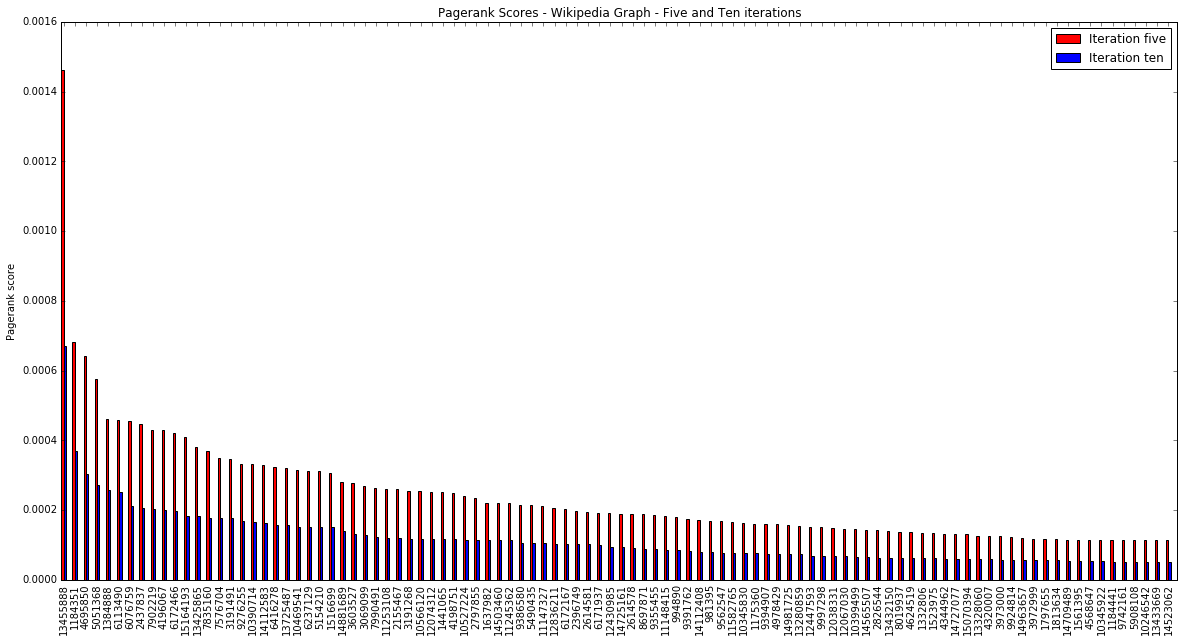

In [88]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = 100
nodes_ten_iterations = []
nodes_five_iterations = []
pagerank_five_iterations = []
pagerank_ten_iterations = []

ind = np.arange(N)  # the x locations for the groups
width = 0.2       # the width of the bars

with open("/home/cloudera/w261/HW9/data/wiki/five_iterations_plot.txt","r") as f:
    for line in f:
        line = line.strip()
        node, pagerank = line.split("\t")
        pagerank = float(pagerank)
        nodes_five_iterations.append(node)
        pagerank_five_iterations.append(pagerank)
    
with open("/home/cloudera/w261/HW9/data/wiki/ten_iterations_plot.txt","r") as f:
    for line in f:
        line = line.strip()
        node, pagerank = line.split("\t")
        pagerank = float(pagerank)
        nodes_ten_iterations.append(node)
        pagerank_ten_iterations.append(pagerank)
    
fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(ind, pagerank_five_iterations, width, color='r')

rects2 = ax.bar(ind + width, pagerank_ten_iterations, width, color='b')

ax.set_ylabel('Pagerank score')

ax.set_title('Pagerank Scores - Wikipedia Graph - Five and Ten iterations')
ax.set_xticks(ind + width)
ax.set_xticklabels(nodes_ten_iterations, rotation='vertical')

ax.legend((rects1[0], rects2[0]), ('Iteration five', 'Iteration ten'))

plt.show()

 <h2 style="color:darkgreen">  HW 9.3 Analysis </h2>




<br><br>

__From the results shown below we can see that the ranking of the pages between iterations five and ten does not significantly change!__ This leads me to believe that, while the algorithm may take many more than ten iterations to converge, since in the case of pagerank what we care about is the relative ordering of the nodes, an appropriate stopping criteria may simply be to stop when the ranking has not changed for the past X iterations.

#### Top 100 nodes by pagerank - Wikipedia graph (fifth iteration)

In [69]:
!aws s3 cp s3://cerc-w261/HW9/wiki/top100_sorted_output_five_iterations \
    /home/cloudera/w261/HW9/data/wiki/top100_sorted_output_five_iterations --recursive --quiet

In [74]:
!cat /home/cloudera/w261/HW9/data/wiki/top100_sorted_output_five_iterations/* | cut -f 1,3

13455888	0.0014607248
1184351	0.000682828
4695850	0.0006429807
5051368	0.0005763793
1384888	0.0004600329
7902219	0.0004581331
6113490	0.0004547314
2437837	0.000445625
6076759	0.0004304041
13425865	0.0004286518
4196067	0.0004220348
6172466	0.0004085202
14112583	0.0003820633
10390714	0.0003685343
15164193	0.0003501337
3191491	0.0003449499
7835160	0.0003320829
6416278	0.0003310909
6237129	0.0003280171
1516699	0.0003248582
13725487	0.0003211215
7576704	0.0003144368
9276255	0.0003126595
10469541	0.0003110539
5154210	0.0003052921
7990491	0.0002798165
12836211	0.0002772498
4198751	0.0002676499
2797855	0.0002630145
11253108	0.0002612684
3603527	0.0002600149
3069099	0.0002535106
9386580	0.0002533372
12074312	0.0002510714
14881689	0.0002504393
2155467	0.0002476649
1441065	0.000240663
14503460	0.0002349039
3191268	0.0002208673
10566120	0.0002204521
2396749	0.0002201284
11147327	0.0002149031
2614581	0.0002148857
1637982	0.000212444
11245362	0.0002070061
12430985	0.0002043623
9355455	0.0001963702
1

#### Top 100 nodes by pagerank - Wikipedia graph (tenth iteration)

In [70]:
!aws s3 cp s3://cerc-w261/HW9/wiki/top100_sorted_output_ten_iterations \
    /home/cloudera/w261/HW9/data/wiki/top100_sorted_output_ten_iterations --recursive --quiet

In [75]:
!cat /home/cloudera/w261/HW9/data/wiki/top100_sorted_output_ten_iterations/* | cut -f 1,3

13455888	0.0006700373
1184351	0.0003700194
4695850	0.0003040226
5051368	0.0002717002
1384888	0.0002572959
6113490	0.0002531746
6076759	0.0002107936
2437837	0.0002055312
7902219	0.0002041113
4196067	0.0002002535
6172466	0.0001970803
15164193	0.0001839921
13425865	0.0001821293
7835160	0.0001772567
7576704	0.0001766931
3191491	0.0001765933
9276255	0.0001692917
10390714	0.000166226
14112583	0.0001630573
6416278	0.0001561166
13725487	0.0001557708
10469541	0.0001526507
6237129	0.0001513093
5154210	0.0001506014
1516699	0.0001503039
14881689	0.0001409856
3603527	0.0001310335
3069099	0.0001286248
7990491	0.0001222571
11253108	0.0001207053
2155467	0.0001193775
3191268	0.0001180683
10566120	0.0001177986
12074312	0.0001167419
1441065	0.0001159875
4198751	0.0001159809
10527224	0.0001151489
2797855	0.0001145955
1637982	0.0001145794
14503460	0.0001144498
11245362	0.0001143317
9386580	0.0001057415
5490435	0.0001056147
11147327	0.0001042031
12836211	0.0001037417
6172167	0.0001035124
2396749	0.000101922

<h2 style="color:red"> HW 9.4: Topic-specific PageRank implementation using MRJob </h2>

Modify your PageRank implementation to produce a topic specific PageRank implementation, as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.   
This caveat lies in footnote 3 on page 3:
```
	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.
```
and must be adhered to for convergence to be guaranteed.   

Run topic specific PageRank on the following randomly generated network of 100 nodes:

> s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

which are organized into ten topics, as described in the file:

> s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

Since there are 10 topics, your result should be 11 PageRank vectors (one for the vanilla PageRank implementation in 9.1, and one for each topic with the topic specific implementation). Print out the top ten ranking nodes and their topics for each of the 11 versions, and comment on your result. Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the requirements for irreducibility with topic-specific PageRank. In particular, the literature ensures irreducibility by requiring that nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed separately for each of the (10) topics.

So, instead of using this method for irreducibility, please comment on why the literature's method is difficult to implement, and what what extra computation it will require.   

Then for your code, please use the alternative, non-uniform damping vector:

```
vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj
```
for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes. If beta > 0.5, PageRank is topic-sensitive, and if beta < 0.5, the PageRank is anti-topic-sensitive. For any value of beta irreducibility should hold, so please try beta=0.99, and perhaps some other values locally, on the smaller networks.

<h2 style="color:darkgreen"> HW 9.4 Implementation </h2>

#### Join Topics with Graph

In [36]:
%%writefile TopicPageRankPrep_1.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast

class TopicPageRankPrep_1MR(MRJob):
    
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_init,
                   mapper=self.mapper
            )
        ]
    in_memory_hash = {}
    def mapper_init(self):
        ## Here we initialize the in-memory hash that
        ## stores nodes and their respective topics
        temp = [s.split("\t") for s in open("node_topics.txt", "r").readlines()]
        for row in temp:
            node = row[0]
            topic = row[1].strip()
            self.in_memory_hash[node] = topic
    
    def mapper(self, _, line):
        ## Map-side memory backed join
        line = line.strip()
        node, payload = line.split("\t")
        node = node.strip('"')
        topic = self.in_memory_hash.get(node)
        if topic:
            yield node, (topic, payload)
        
    
if __name__ == '__main__':
    TopicPageRankPrep_1MR().run()

Overwriting TopicPageRankPrep_1.py


In [37]:
!chmod a+x TopicPageRankPrep_1.py

In [31]:
%%writefile PageRank_graph_prep_TS.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class MRpageRankGraphPrepTS(MRJob):
    
    num_nodes = 0
    
    def step(self):
        
        return [
            MRStep(
                   mapper=self.mapper,
                   reducer=self.reducer)
        ]
    
    def mapper(self, _, line):
        line = line.strip()
        key, value = line.split("\t")
        key = key.strip('"')
        value = ast.literal_eval(value)
        topic, neighbors = value[0], value[1]
        neighbors = ast.literal_eval(neighbors)
        neighbors_array = []
        ## we have counters for the total nodes
        ## as well as the topic-specific node counts
        self.increment_counter("numNodes", topic, 1)
        self.increment_counter("numNodes","vanilla",1)
        for n in neighbors.keys():
            neighbors_array.append(n)
            yield n, "-"
        yield key, (topic, neighbors_array)
        
    def reducer(self, key, values):
        neighbors = []
        for v in values:
            topic = v[0]
            if neighbors == "":
                if v != "-":
                    neighbors = v[1]
            else:
                if v != "-":
                    neighbors.extend(v[1])
        yield key, (topic, neighbors, 1.0)
        
if __name__ == "__main__":
    MRpageRankGraphPrepTS.run()

Overwriting PageRank_graph_prep_TS.py


In [32]:
!chmod a+x PageRank_graph_prep_TS.py

In [2]:
%%writefile TopicPageRank_step1.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class TopicMRpageRank_step1MR(MRJob):
    
    ## Hardcoding the job parameters;
    ## these are substituted with runtime parameters
    N = 1
    alpha = 0.0
    first_run = 0
    dangling_mass = 0.0
    
    ## function permits us to pass a binary first run indicator as well as 
    ## the number of nodes in the graph to our mrjob
    def configure_options(self):
        super(TopicMRpageRank_step1MR, self).configure_options()
        self.add_passthrough_option('--first-run', type='int', default=0, help='Indicates whether we are dealing with the first run of algo')
        self.add_passthrough_option('--num-nodes', type='int', default=1, help='The number of nodes in the graph; must be an int!')
    
    def steps(self):
        return [
            MRStep(
            mapper_init=self.mapper_init,
            mapper=self.mapper,
            reducer_init=self.reducer_init,
            reducer=self.reducer)
        ]
    
    def mapper_init(self):
        self.N = self.options.num_nodes
        self.first_run = self.options.first_run
    
    def mapper(self, _, line):
        line = line.strip()
        key, value = line.split("\t")
        key = key.strip('"')
        value = ast.literal_eval(value)
        topic = value[0]
        neighbors = value[1]
        ## If this is the first run we must initialize
        ## the pagerank value for each node,
        ## alternatively we simply set it
        if self.first_run == 1:
            PR = float(value[2]) / float(self.N)
        else:
            PR = float(value[2])
        ## we emit a special key with the dangling mass when
        ## we encounter a node with no outlinks
        if neighbors == []:
            yield "*dangling", ("-","-", float(PR))
            yield key, (topic, neighbors, 0.0)
        else:
            num_nieghbors = len(neighbors)
            for n in neighbors:
                yield n, ("-","-",float(PR)/float(num_nieghbors))
            yield key, (topic, neighbors, 0.0)
    
    def reducer_init(self):
        self.N = self.options.num_nodes
    
    def reducer(self, key, values):
        dangling_mass = 0.0
        ## When dangling nodes are encountered, their
        ## mass is accumulated in a counter
        if key == "*dangling":
            for v in values:
                dangling_mass += v[2]
            TEN_BILLION = 10000000000
            self.increment_counter("dangling_nodes","mass", int(dangling_mass*TEN_BILLION))
        else:
            new_PR = 0.0
            neighbors = ""
            for v in values:
                new_PR += v[2]
                if v[1] != "-":
                    topic = v[0]
                    neighbors = v[1]
            yield key, (topic, neighbors, new_PR)
        
if __name__ == "__main__":
    TopicMRpageRank_step1MR.run()

Overwriting TopicPageRank_step1.py


In [3]:
!chmod a+x TopicPageRank_step1.py

########################################
########################################

An important thing to note in the below processing MR job is that the job could have been executed just with reducers, with both mappers and reducers as well as just with mappers. __I explicitly choose to execute the task with just mappers as a time and resources optimization: by only using mappers the MapReduce job does not engage in the shuffle and sort phase which saves us both time and network bandwidth costs.__

########################################
########################################

In [31]:
%%writefile TopicPageRank_step2.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class TopicPageRank_step2MR(MRJob):
    
    ## Hardcoding the job parameters;
    ## these are substituted with runtime parameters
    N = 1
    alpha = 0.0
    first_run = 0
    dangling_mass = 0.0
    beta = 0.0
    topic = "vanilla"
    
    ## function permits us to pass an arbitrary alpha, beta, number of nodes,
    ## dangling mass and/or topic to our mrjob
    def configure_options(self):
        super(TopicPageRank_step2MR, self).configure_options()
        self.add_passthrough_option('--beta', type='float', default=0.0, help='The beta factor; must be a float!')
        self.add_passthrough_option('--alpha', type='float', default=0.1, help='The damping factor; must be a float!')
        self.add_passthrough_option('--num-nodes', type='int', default=1, help='The number of nodes in the graph; must be an int!')
        self.add_passthrough_option('--dangling-mass', type='float', default=0.0, help='The dangling mass for iteration; must be a float!')
        self.add_passthrough_option('--topic', type='str', default="vanilla", help='The topic; must be a string!')
        
    def steps(self):
        return [
            MRStep(
            mapper_init=self.mapper_init,
            mapper=self.mapper)
        ]
    
    def mapper_init(self):
        self.alpha = self.options.alpha
        self.N = self.options.num_nodes
        self.dangling_mass = self.options.dangling_mass
        self.beta = self.options.beta
        self.topic = self.options.topic
        self.numNodes = {}
        with open("numNodes.txt","r") as f:
            for line in f:
                line = line.strip()
                topic, number_of_nodes = line.split("\t")
                self.numNodes[topic] = number_of_nodes
    
    def mapper(self, _, line):
        line = line.strip()
        key, value = line.split("\t")
        key = key.strip('"')
        value = ast.literal_eval(value)
        topic = value[0]
        neighbors = value[1]
        PR = float(value[2])
        ## Depending on the topic of the node and the topic being analyzed
        ## we compute the final pagerank differently
        if topic == self.topic:
            dampening_component = float(self.beta) * (1.0 / float(self.numNodes[topic]))
        elif self.topic == "vanilla":
            dampening_component = 1.00/float(self.N)
        else:
            dampening_component = (1.0 - float(self.beta)) * (1.0 /(float(self.N) - float(self.numNodes[topic])))
        PR = self.alpha * dampening_component + (1.0 - self.alpha) * (PR  + (self.dangling_mass / float(self.N)))
        yield key, (topic, neighbors, PR)
        
if __name__ == "__main__":
    TopicPageRank_step2MR.run()

Overwriting TopicPageRank_step2.py


In [32]:
!chmod a+x TopicPageRank_step2.py

In [38]:
%%writefile top10_final.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
import ast
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class MRtop10_final(MRJob):
    
    # Settings for sorting
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        ## Note that we are explicitly setting 
        ## multiple reducers in the first step, we are considering the 
        ## full output of the mappers as a key for the
        ## shuffle phase, setting partitioners based on 
        ## artificial partition keys and we are sorting
        ## based on the transformed pagerank values
        JOB_CONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 4,
            'stream.map.output.field.separator':'/t',
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.partition.keycomparator.options': '-k4,4nr',
             'mapreduce.job.reduces': 10,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        
        JOB_CONF_STEP_2 = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 3,
            'stream.map.output.field.separator':'/t',
            'mapreduce.partition.keycomparator.options': '-k3,3nr',
             'mapreduce.job.reduces': 1,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        
        return [
            MRStep(jobconf=JOB_CONF_STEP,
                   mapper=self.mapper,
                   reducer_init=self.reducer_init,
                   reducer=self.reducer
            ),
            MRStep(jobconf=JOB_CONF_STEP_2,
                   mapper=self.mapper2,
                   reducer_init=self.reducer_init2,
                   reducer=self.reducer2
            )
        ]
    
    ## Notice that we are emmitting artificial 
    ## keys to ensure that the partitioners can 
    ## key off of them and guarantee sorted output
    
    def mapper(self, _, line):
        TEN_BILLION = 10000000000
        line = line.strip()
        key, value = line.split("\t")
        key = key.strip('"')
        value = ast.literal_eval(value)
        neighbors = value[1]
        PR = float(value[2])
        ## for the purposes of properly sorting I transform the 
        ## pageranks into integers
        PR = int(PR*TEN_BILLION)
        if PR >= int(0.0001*TEN_BILLION):
            yield 'a', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.00001*TEN_BILLION):
            yield 'b', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.000001*TEN_BILLION):
            yield 'c', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.0000001*TEN_BILLION):
            yield 'd', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.00000001*TEN_BILLION):
            yield 'e', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.000000001*TEN_BILLION):
            yield 'f', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.0000000001*TEN_BILLION):
            yield 'g', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.00000000001*TEN_BILLION):
            yield 'h', key+"\t"+str(neighbors)+"\t"+str(PR)
        elif PR >= int(0.000000000001*TEN_BILLION):
            yield 'i', key+"\t"+str(neighbors)+"\t"+str(PR)
        else:
            yield 'j', key+"\t"+str(neighbors)+"\t"+str(PR)
            
    def reducer_init(self):
        self.top10_counter = 0
        
    def reducer_init2(self):
        self.top10_counter = 0
            
    def reducer(self,key,value):
        ## Here we only emit the top 10 entries for each reducer
        for v in value:
            v = v.strip()
            if self.top10_counter < 10:
                self.top10_counter += 1
                yield None, v
                
    def reducer2(self, key, value):
        key = key.strip()
        key = key.strip('"')
        TEN_BILLION = 10000000000
        for v in value:
            v = v.strip()
            neighbors, PR = v.split("\t")
            ## Transform pagerank back to float for final emission
            PR = float(PR) / float(TEN_BILLION)
            if self.top10_counter < 10:
                self.top10_counter += 1
                yield key, str(neighbors)+"\t"+str(PR)
                
    def mapper2(self, key, value):
        ## The mapper simply sends the node and the payload
        ## as our objective is to use sorting in the shuffle
        ## and sort phase
        key = key.strip()
        value = value.strip()
        neighbors, PR = value.split("\t")
        key = key.strip('"')
        yield key, str(neighbors)+"\t"+str(PR)
        
if __name__ == "__main__":
    MRtop10_final().run()

Writing top10_final.py


In [44]:
!chmod a+x top10_final.py

#### Topic-specific PageRank Implementation

##### Input Preprocessing Step

The step below enhances the graph with the node topics.

In [1]:
!python TopicPageRankPrep_1.py /home/cloudera/w261/HW9/data/random/randNet/randNet.txt \
--file="/home/cloudera/w261/HW9/data/random/randNet_topics/randNet_topics.txt#node_topics.txt" \
--output-dir=/home/cloudera/w261/HW9/data/random/preinput --no-output

Using configs in /home/cloudera/.mrjob.conf
Running step 1 of 1...
Creating temp directory /tmp/TopicPageRankPrep_1.cloudera.20160720.162229.647374
Removing temp directory /tmp/TopicPageRankPrep_1.cloudera.20160720.162229.647374...


########################################
########################################
##### Iterative Processing Steps

For each of the topics (as well as the vanilla case) I run the iterative pagerank algorithm for ten iterations. Much like the implementations in the earlier sections, there is first a preprocessing step that fleshes out the dangling nodes and also counts the number of nodes (In this case the job counts the number of nodes in each of the topics). Then, each iteration has two MR jobs, the first where dangling mass is accumulated and pagerank is spread from nodes through thier edges. The second MR job spreads the dangling mass evernly across all nodes and then calculates the final pagerank for the iteration, which I modified to comply with the irreducibility in the topic-specific pagerank case by changing the dampening vector into one that is dependent on the topic being analyzed, the topic of the node being processed and a sensitivity parameter, beta.

########################################
########################################

In [57]:
%reload_ext autoreload
%autoreload 2

from PageRank_graph_prep_TS import MRpageRankGraphPrepTS
from TopicPageRank_step1 import TopicMRpageRank_step1MR
from TopicPageRank_step2 import TopicPageRank_step2MR
import ast
import os
from numpy import random,array

!rm -r /home/cloudera/w261/HW9/data/random/input
!rm -r /home/cloudera/w261/HW9/data/random/intermediate_input
!mkdir -p /home/cloudera/w261/HW9/data/random/input
!mkdir -p /home/cloudera/w261/HW9/data/random/intermediate_input

mr_job = MRpageRankGraphPrepTS(args=[
        "-r","local",
        "/home/cloudera/w261/HW9/data/random/preinput",
        "--output-dir","/home/cloudera/w261/HW9/data/random/input"
    ])

numNodes = {}

with mr_job.make_runner() as runner: 
        runner.run()
        counters = runner.counters()[0]
        ## Here we collect the number of nodes for each of the topics
        ## and for the vanilla case to be passed on to the second MR Job
        ## for the iteration
        numNodes["vanilla"] = counters['numNodes']['vanilla']
        for topic in range(1,11):
            topic = str(topic)
            numNodes[topic] = counters['numNodes'][topic]

with open("/home/cloudera/w261/HW9/data/random/numNodes/numNodes.txt", "w") as f:
    for topic in range(1,11):
        topic = str(topic)
        f.write("%s\t%s\n"%(topic, numNodes[topic]))
    f.write("vanilla\t%s\n"%numNodes["vanilla"])

for topic in numNodes.keys():

    i = 0
    TEN_BILLION = 10000000000
    while(1):
        if i == 0:
            first_run = 1
        else:
            first_run = 0
        mr_job = TopicMRpageRank_step1MR(args=[
                "-r","local",
                "/home/cloudera/w261/HW9/data/random/input",
                "--num-nodes", str(numNodes["vanilla"]),
                "--first-run", str(first_run),
                "--output-dir","/home/cloudera/w261/HW9/data/random/intermediate_input"
            ])

        print "iteration "+str(i)+" of Pagerank algorithm"

        with mr_job.make_runner() as runner: 
                runner.run()
                counters = runner.counters()[0]
                if not counters.get("dangling_nodes"):
                    dangling_nodes_mass = 0.0
                else:
                    dangling_nodes_mass = float(counters["dangling_nodes"]["mass"]) / float(TEN_BILLION)

        mr_job = TopicPageRank_step2MR(args=["/home/cloudera/w261/HW9/data/random/intermediate_input",
                                   "--alpha",0.15,
                                    "--beta",0.01,
                                   "--num-nodes", str(numNodes["vanilla"]),
                                   "--dangling-mass",str(dangling_nodes_mass),
                                    "topic", topic,
                                    "--file", "/home/cloudera/w261/HW9/data/random/numNodes/numNodes.txt#numNodes.txt",
                                    "--output-dir",
                                   "/home/cloudera/w261/HW9/data/random/output"])

        with mr_job.make_runner() as runner: 
            runner.run()

        i = i + 1

        !rm -r /home/cloudera/w261/HW9/data/random/input
        !rm -r /home/cloudera/w261/HW9/data/random/intermediate_input
        !cp -rT /home/cloudera/w261/HW9/data/random/output /home/cloudera/w261/HW9/data/random/input
        !rm -r /home/cloudera/w261/HW9/data/random/output

        if i >=10:
            break
    !cp -rT /home/cloudera/w261/HW9/data/random/input /home/cloudera/w261/HW9/data/random/final_output/topic_$topic

rm: cannot remove `/home/cloudera/w261/HW9/data/random/intermediate_input': No such file or directory
iteration 0 of Pagerank algorithm
iteration 1 of Pagerank algorithm
iteration 2 of Pagerank algorithm
iteration 3 of Pagerank algorithm
iteration 4 of Pagerank algorithm
iteration 5 of Pagerank algorithm
iteration 6 of Pagerank algorithm
iteration 7 of Pagerank algorithm
iteration 8 of Pagerank algorithm
iteration 9 of Pagerank algorithm
iteration 0 of Pagerank algorithm
iteration 1 of Pagerank algorithm
iteration 2 of Pagerank algorithm
iteration 3 of Pagerank algorithm
iteration 4 of Pagerank algorithm
iteration 5 of Pagerank algorithm
iteration 6 of Pagerank algorithm
iteration 7 of Pagerank algorithm
iteration 8 of Pagerank algorithm
iteration 9 of Pagerank algorithm
iteration 0 of Pagerank algorithm
iteration 1 of Pagerank algorithm
iteration 2 of Pagerank algorithm
iteration 3 of Pagerank algorithm
iteration 4 of Pagerank algorithm
iteration 5 of Pagerank algorithm
iteration 6 of

########################################
########################################

##### Top 10 count per topic

Next I made use of an EMR cluster to sort and filter the top ten nodes by pagerank for each of the pagerank vectors calculated above. Finally I brought those sorted top ten vectors back down locally and displayed them below.

########################################
########################################

In [61]:
%reload_ext autoreload
%autoreload 2

from top10_final import MRtop10_final

with open("/home/cloudera/w261/HW9/data/random/numNodes/numNodes.txt", "r") as f:
    for line in f:
        line = line.strip()
        topic, numNodes = line.split("\t")
        topic = topic.strip('"')

        !aws s3 rm s3://cerc-w261/HW9/random/final_output/topic_$topic --recursive --quiet

        mr_job = MRtop10_final(args=["-r","emr",
                                       "s3://cerc-w261/HW9/random/output/topic_%s"%topic,
                                       "--cluster-id=j-B9BK45Z0SIAU",
                                        "--aws-region=us-west-2",
                                       "--output-dir",
                                       "s3://cerc-w261/HW9/random/final_output/topic_%s"%topic])

        with mr_job.make_runner() as runner: 
                runner.run()

In [64]:
with open("/home/cloudera/w261/HW9/data/random/numNodes/numNodes.txt", "r") as f:
    for line in f:
        line = line.strip()
        topic, numNodes = line.split("\t")
        topic = topic.strip('"')
        !aws s3 cp s3://cerc-w261/HW9/random/final_output/topic_$topic \
            /home/cloudera/w261/HW9/data/random/top10_final_output/topic_$topic \
            --recursive --quiet

In [68]:
with open("/home/cloudera/w261/HW9/data/random/numNodes/numNodes.txt", "r") as f:
    for line in f:
        line = line.strip()
        topic, numNodes = line.split("\t")
        topic = topic.strip('"')
        if topic != "vanilla":
            print "###################################################"
            print "Top 10 nodes by topic-specific Pagerank (Topic %s)"%topic
            print "###################################################"
            !cat /home/cloudera/w261/HW9/data/random/top10_final_output/topic_$topic/* | cut -f 1,3
            print "###################################################"
        else:
            print "###################################################"
            print "Top 10 nodes by non-topic-specific Pagerank"
            print "###################################################"
            !cat /home/cloudera/w261/HW9/data/random/top10_final_output/topic_$topic/* | cut -f 1,3
            print "###################################################"

###################################################
Top 10 nodes by topic-specific Pagerank (Topic 1)
###################################################
15	0.0129027274
74	0.012583424
63	0.0125174428
100	0.0122208097
85	0.0119959521
9	0.0119503857
58	0.0117280627
71	0.011482683
61	0.0114258042
52	0.0113191821
###################################################
###################################################
Top 10 nodes by topic-specific Pagerank (Topic 2)
###################################################
15	0.012902714
74	0.0125834108
63	0.0125174302
100	0.0122207975
85	0.0119959398
9	0.0119503738
58	0.0117280507
71	0.0114826713
61	0.0114257926
52	0.0113191705
###################################################
###################################################
Top 10 nodes by topic-specific Pagerank (Topic 3)
###################################################
15	0.0129027141
74	0.0125834109
63	0.0125174302
100	0.0122207975
85	0.0119959398
9	0.0119503738
58	0.0117280507
71	0.

In [60]:
## first we spool up a cluster
!mrjob create-cluster \
--max-hours-idle 1 \
--aws-region=us-west-2 -c ~/.mrjob.conf

Using s3://mrjob-4b78edd1b5baad75/tmp/ as our temp dir on S3
Creating persistent cluster to run several jobs in...
Creating temp directory /tmp/no_script.cloudera.20160721.121023.884455
Copying local files to s3://mrjob-4b78edd1b5baad75/tmp/no_script.cloudera.20160721.121023.884455/files/...
j-B9BK45Z0SIAU


<h2 style="color:darkgreen">  HW 9.4 Analysis </h2>


Above you can see the printed out top ten nodes by topic-specific pagerank for each of the ten topics as well as the top ten nodes by non-topic-specific pagerank.

For the parameters defined in the job (specifically the beta coefficient close to zero) I expected to see that the topic-specific pagerank results would not be sensitive to the non-uniform dampening vector. This is clear from the results above as the results while some may have slightly different pagerank values across the topics, the ordering of the nodes does not change.

Finally, it is important to highlight why the literature's recommended approach of constructing topic-specific pagerank may not be such a good idea. To comply with the irreducibility requirement, the literature suggests an implementation where nodes not reachable from in-topic nodes be removed from the network. Since the graph structure needs to be passed across all MapReduce jobs that are processing the pagerank iterations, and each of the topic-specific pagerank algorithms would require its own specific version of the graph, we would need to run a preprocessing MapReduce job for each of the topics that would output the topic-specif graph to go through the iterative algorithm. As such, as the number of topics grows, so does the preprocessing number of MapReduce jobs (linearly) grow with it.

__As future work, I would like to consolidate the construction of the topic-specific pagerank vectors into a single iterative process as opposed to having one for each of the topics. This should dramiatically cut down on the time to execute of the algorithm at the time of running at scale. This approach was not taken to optimize for time.__

<center><div class='jumbotron'><h3 style='color:darkblue'>---------  OPTIONAL QUESTIONS SECTION --------</h3></div></center>

<h2 style="color:red"> HW 9.5: (OPTIONAL) Applying topic-specific PageRank to Wikipedia</h2>

Here you will apply your topic-specific PageRank implementation to Wikipedia, defining topics (very arbitrarily) for each page by the length (number of characters) of the name of the article mod 10, so that there are 10 topics. 

* Once again, print out the top ten ranking nodes and their topics for each of the 11 versions, and comment on your result. Assume a teleportation factor of 0.15 in all your analyses. Run for 10 iterations.
* Plot the pagerank values for the top 100 pages resulting from the 5 iterations run in HW 9.3. 
* Then plot the pagerank values for the same 100 pages that result from the topic specific pagerank after 10 iterations run. 
* Comment on your findings. 

<h2 style="color:darkgreen"> HW 9.5 Implementation </h2>

In [1]:
## Code goes here

In [2]:
## Drivers & Runners

In [3]:
## Run Scripts, S3 Sync

<h2 style="color:darkgreen">  HW 9.5 Analysis </h2>




<br><br>

<h2 style="color:red"> HW 9.6:  (OPTIONAL) TextRank</h2>

* What is TextRank? Describe the main steps in the algorithm. Why does TextRank work?
* Implement TextRank in MrJob for keyword phrases (not just unigrams) extraction using co-occurrence based similarity measure with with sizes of N = 2 and 3. And evaluate your code using the following example using precision, recall, and FBeta (Beta=1):
```
"Compatibility of systems of linear constraints over the set of natural numbers
Criteria of compatibility of a system of linear Diophantine equations, strict 
inequations, and nonstrict inequations are considered. Upper bounds for
components of a minimal set of solutions and algorithms of construction of 
minimal generating sets of solutions for all types of systems are given. 
These criteria and the corresponding algorithms for constructing a minimal 
supporting set of solutions can be used in solving all the considered types of 
systems and systems of mixed types." 
```
* The extracted keywords should in the following set:
```
linear constraints, linear diophantine equations, natural numbers, non-strict inequations, strict inequations, upper bounds
```

<h2 style="color:darkgreen"> HW 9.6 Implementation </h2>

In [1]:
## Code goes here

In [2]:
## Drivers & Runners

In [3]:
## Run Scripts, S3 Sync

<h2 style="color:darkgreen">  HW 9.6 Analysis </h2>




<br><br>

<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HWK 9 --------</h2></div></center>